In [1]:
##############################################################
###  setup to use GPU TensorFlow on high-RAM Colab -- cwr  ###
##############################################################

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()

# Signed up for Colab Pro on December 1, 2021
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Dec  3 21:42:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    33W / 250W |    375MiB / 16280MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
random_seed = 20211202

# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'
# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

# max_input_images = 10
# max_input_images = 100
# max_input_images = 200
# max_input_images = 300
# max_input_images = 500
# max_input_images = 1000
max_input_images = 'all'

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# Disk diameter, relative to full sized megapixel image.
disk_size = 201

# For scaling down the input image size.
# input_scale = 1
input_scale = 0.125
# input_scale = 0.25
# input_scale = 0.5
if (input_scale != 1):
    fcd_image_size = int(fcd_image_size * input_scale)
    disk_size = int(disk_size * input_scale)

In [3]:
import PIL
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from numpy import asarray
from matplotlib import image
import matplotlib.pyplot as plt

# from DLAVA, includes unused symbols, maybe tighten later
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# # trying to get around memory limits:
# from random import sample
import random

# 20211128 temp?
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# Progress bar utility
from tqdm.auto import tqdm

import time

In [4]:
#####################
####  Utilities  ####
#####################

# Prints "expression = <value>"
def debug_print(expression):
    print(expression, '=', eval(expression))

# Reset random sequence seeds in both "numpy" and "random".
def reset_random_seeds():
    random.seed(random_seed)
    np.random.seed(random_seed)

# Parse FCD filename to a list of (x, y) pixel coordinates.
def fcd_filename_to_xy_pair(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    two_ints = list(map(int, two_numeric_strings))
    return two_ints

# # Get image label from image file names ([x, y] as floats on [0,1])
# def fcd_normalized_xy(filename, pixels):
#     pixel_coordinates = fcd_filename_to_xy_pair(filename)
#     normalized = [pixel_coordinates[0] / pixels.shape[0],
#                   pixel_coordinates[1] / pixels.shape[1]]
#     return normalized

################# 20211202 find a more elegant way to code this:

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_pair(filename)
    normalized = [pixel_coordinates[0] / (pixels.shape[0] / input_scale),
                  pixel_coordinates[1] / (pixels.shape[1] / input_scale)]
    return normalized

# Draw image on log from given numpy tensor of rgb pixels.
# Optionally draw crosshairs to show center of disk.
def draw_image(rgb_pixel_tensor, center=(0,0)):
    plt.imshow(Image.fromarray(rgb_pixel_tensor))
    if (center != (0,0)):
        draw_crosshairs(center)
    plt.show()

# Draw crosshairs to indicate disk position (label or estimate).
def draw_crosshairs(center):
    m = fcd_image_size - 1   # max image coordinate
    s = disk_size * 1.2 / 2  # gap size (radius)
    h = center[0] * m        # center x in pixels
    v = center[1] * m        # center y in pixels
    plt.hlines(v, 0, max(0, h - s), color="black")
    plt.hlines(v, min(m, h + s), m, color="black")
    plt.vlines(h, 0, max(0, v - s), color="white")
    plt.vlines(h, min(m, v + s), m, color="white")

# Draw line in plot between arbitrary points in plot.
# eg: draw_line((100, 100), (924, 924), color="yellow")
def draw_line(p1, p2, color="white"):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color)

In [5]:
############################### SANDBOX ###############################

# def test():
#     # big_array = np.zeros([2000 * 8, 128, 128, 3])
#     # debug_print('big_array.shape')
#     # debug_print('big_array[12345, 67, 58, 1]')
#     # print(big_array[12345, 67, 58, 1])
#     filename = 'vkbrxedwxK_825_668.jpeg'
#     image = Image.open(fcd_ts_dir + filename)
#     pixels = asarray(image)
#     center_position = fcd_normalized_xy(filename, pixels)
#     print('center_position =', center_position)
#     print('input_scale =', input_scale)
    
#     def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
#     def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])

#     for i in range(8):
#         draw_image(pixels, center_position)
#         if (i < 7):
#             if (i == 3):
#                 pixels = np.flip(pixels, axis=1)
#                 center_position = center_flip(center_position)
#             else:
#                     pixels = np.rot90(pixels, k=1, axes=(0, 1))
#                     center_position = center_rot90(center_position)

# test()

# def add_to_traing_set(pixels, center_position, training_images, training_labels):
#     # big_array = np.zeros([2000 * 8, 128, 128, 3])
#     # debug_print('big_array.shape')
#     # debug_print('big_array[12345, 67, 58, 1]')
#     # # print(big_array[12345, 67, 58, 1])
#     # filename = 'vkbrxedwxK_825_668.jpeg'
#     # image = Image.open(fcd_ts_dir + filename)
#     # # pixels = asarray(image)
#     # # center_position = fcd_normalized_xy(filename, pixels)
#     # print('center_position =', center_position)
#     # print('input_scale =', input_scale)
    
#     def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
#     def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])

#     for i in range(8):
#         draw_image(pixels, center_position)

#         # Copy this pixel data into slice "image_index" of "local_images"
#         local_images[image_index, :, :, :] = scaled_pixels
#         # Copy disk center XY position into slice of "local_labels".
#         center_position = fcd_normalized_xy(filename, pixels)
#         local_labels[image_index, :] = center_position

#         if (i < 7):
#             if (i == 3):
#                 pixels = np.flip(pixels, axis=1)
#                 center_position = center_flip(center_position)
#             else:
#                     pixels = np.rot90(pixels, k=1, axes=(0, 1))
#                     center_position = center_rot90(center_position)

In [6]:
# Loads FCD training data image files from "directory_pathname". Returns an
# array of images and an array of labels (each an XY pair, the relative position
# of the disk center). Optional "image_count" can to limit the number of images
# read, by taking a random sample of availble image files, defaults to "all".

# def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
#     directory_contents = listdir(directory_pathname)
#     if (image_count == 'all'): image_count = len(directory_contents)
#     assert image_count <= len(directory_contents), "Too few images in directory"
#     directory_contents = random.sample(directory_contents, image_count)
#     local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
#     local_labels = np.zeros([image_count, 2])
#     image_index = 0
#     for filename in tqdm(directory_contents):
#         image_pathname = join(directory_pathname, filename)
#         # Numpy pixel array of image object.
#         image = Image.open(image_pathname)
#         pixels = asarray(image.resize((fcd_image_size, fcd_image_size),
#                                       PIL.Image.LANCZOS))
#         # Convert input image data to floating-point.
#         float_pixels = keras_backend.cast_to_floatx(pixels)
#         # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
#         scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
#         # Copy this pixel data into slice "image_index" of "local_images"
#         local_images[image_index, :, :, :] = scaled_pixels
#         # Copy disk center XY position into slice of "local_labels".
#         center_position = fcd_normalized_xy(filename, pixels)
#         local_labels[image_index, :] = center_position
#         # Progress report (runs for about 6 minutes for 2000 images on 20211127)
#         image_index += 1
#         if ((image_index % 50) == 0):
#             # show_image_from_rgb_pixel_tensor(pixels)
#             # show_image_from_rgb_pixel_tensor(pixels, center_position)
#             draw_image(pixels, center_position)
#             print(image_index, "images...")
#     return local_images, local_labels

def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
    directory_contents = listdir(directory_pathname)
    if (image_count == 'all'): image_count = len(directory_contents)
    assert image_count <= len(directory_contents), "Too few images in directory"
    directory_contents = random.sample(directory_contents, image_count)
    ###
    image_count *= 8 # for rot/mir
    ###
    local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
    local_labels = np.zeros([image_count, 2])
    image_index = 0
    for filename in tqdm(directory_contents):
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        image = Image.open(image_pathname)
        pixels = asarray(image.resize((fcd_image_size, fcd_image_size),
                                      PIL.Image.LANCZOS))
        # Convert input image data to floating-point.
        float_pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
        #
        #
        # # Copy this pixel data into slice "image_index" of "local_images"
        # local_images[image_index, :, :, :] = scaled_pixels
        # # Copy disk center XY position into slice of "local_labels".
        # center_position = fcd_normalized_xy(filename, pixels)
        # local_labels[image_index, :] = center_position

        center_position = fcd_normalized_xy(filename, pixels)
        def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
        def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])

        #
        #
        # Progress report (runs for about 6 minutes for 2000 images on 20211127)
        # image_index += 1
        if ((image_index % 50) == 0):
            # show_image_from_rgb_pixel_tensor(pixels)
            # show_image_from_rgb_pixel_tensor(pixels, center_position)
            draw_image(pixels, center_position)
            print(image_index, "images...")

        for i in range(8):
            # draw_image(pixels, center_position)
            # draw_image(scaled_pixels, center_position)

            # Copy this pixel data into slice "image_index" of "local_images"
            local_images[image_index, :, :, :] = scaled_pixels
            # Copy disk center XY position into slice of "local_labels".
            # center_position = fcd_normalized_xy(filename, pixels)
            local_labels[image_index, :] = center_position

            image_index += 1

            if (i < 7):
                if (i == 3):
                    scaled_pixels = np.flip(scaled_pixels, axis=1)
                    center_position = center_flip(center_position)
                else:
                        scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
                        center_position = center_rot90(center_position)
        #
        #
        # # Progress report (runs for about 6 minutes for 2000 images on 20211127)
        # # image_index += 1
        # if ((image_index % 50) == 0):
        #     # show_image_from_rgb_pixel_tensor(pixels)
        #     # show_image_from_rgb_pixel_tensor(pixels, center_position)
        #     draw_image(pixels, center_position)
        #     print(image_index, "images...")
    return local_images, local_labels

In [7]:
# Construct a striding CNN Keras model (cribbed from DLAVA chapter B3, Listing
# B3-41): currently 2 Conv2D with dropout, then 2 dense, outpu layer is dense
# with just two neurons, to generate an XY position estimate for the disk.

def make_striding_cnn_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), activation='relu', padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3),
                     # input_shape=(image_height, image_width, 1)))
                     input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    #
    # instead of softmax, maybe a Dense layer with two neurons (x, y)?
    #
    # model.add(Dense(number_of_classes, activation='softmax'))
    # Just guessing here:
    model.add(Dense(2, activation='relu'))
    #
    # Use MSE in place of categorical_crossentropy
    # since my problem is more like regression
    #
    # model.compile(loss='categorical_crossentropy', optimizer='adam', 
    #               metrics=["accuracy"])
    # model.compile(loss=tf.keras.losses.MeanSquaredError(),
    #               optimizer='adam',
    #               metrics=["accuracy"])
    #
    # 20211128 following example from here:
    # https://stackoverflow.com/q/55884849/1991373
    #
    # model.compile(loss=[tf.keras.losses.MeanSquaredError(),
    #                     tf.keras.losses.MeanSquaredError()],
    #               optimizer='adam',
    #               metrics=["accuracy"])
    # model.compile(loss=['mse', 'mse'],
    #               optimizer='adam',
    #               metrics=["accuracy"])
    model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
    # model.compile(loss=['mse', 'mse'], optimizer='adam', metrics=["accuracy"])
    return model

In [8]:
# Utility to fit and plot a run, again cribbed from DLAVA chapter B3.
def run_model(model_maker, plot_title):
    model = model_maker()
    #
    print("In run_model():")
    debug_print('X_train.shape')
    debug_print("y_train.shape")
    #
    history = model.fit(X_train, y_train,
                        validation_split=0.25,
                        # epochs=100, batch_size=256) ####################
                        # epochs=100, batch_size=10)
                        # epochs=100, batch_size=4)
                        epochs=100, batch_size=32)
    plot_accuracy_and_loss(history, plot_title)
    return history

# A little utility to draw plots of accuracy and loss.
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    plt.show()

Reading all images from /content/drive/My Drive/PredatorEye/fcd_training_set/


  0%|          | 0/2007 [00:00<?, ?it/s]

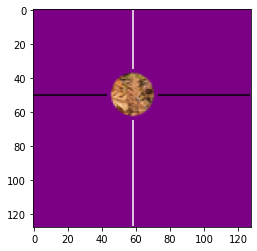

0 images...


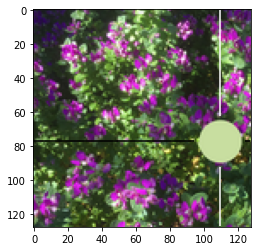

200 images...


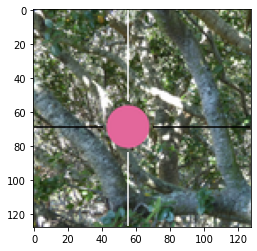

400 images...


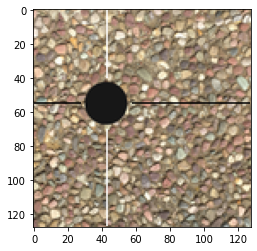

600 images...


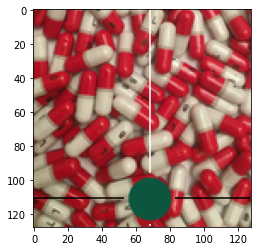

800 images...


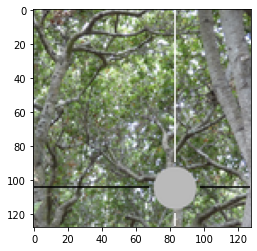

1000 images...


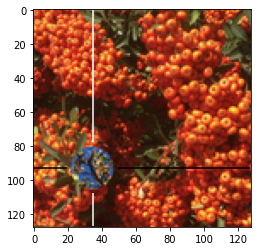

1200 images...


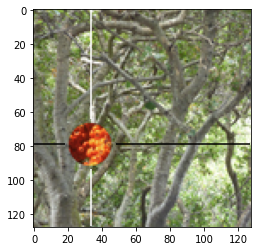

1400 images...


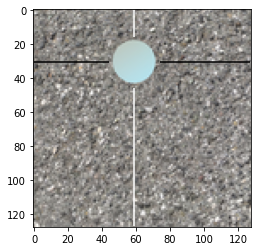

1600 images...


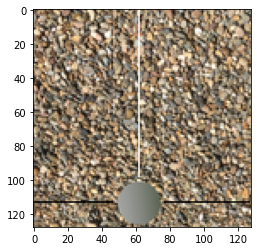

1800 images...


KeyboardInterrupt: ignored

In [9]:
# Read FCD training data from a given directory.
reset_random_seeds()
start_time = time.time()
print('Reading', max_input_images, 'images from ' + fcd_ts_dir)

X_train = []  # Clear these to release the memory early?
y_train = []
X_train, y_train = read_fcd_data_from_directory(fcd_ts_dir, max_input_images)

print('Read', X_train.shape[0], 'training images.')
print('Elapsed time:', int(time.time() - start_time), 'seconds.')

In [ ]:
# Run a model.
reset_random_seeds()
striding_history = [] # To release memory when rerunning in notebook?
striding_history = run_model(make_striding_cnn_model, 'FCD: Striding CNN')